# **Introduction to TinyAutoML**

---

TinyAutoML is a Machine Learning Python3.9 library thought as an extension of Scikit-Learn. It builds adaptable and auto-tuned pipeline to handle binary classification tasks.

In a few words, your data go through 2 main preprocessing steps. The first one is scaling and NonStationnarity correction, which is followed by Lasso Feature selection. 

Finally, one of the three MetaModels is fitted on the transformed data.

Lets import the library !

In [ ]:
!pip install TinyAutoML==0.2.3

In [1]:
from TinyAutoML.Models import *
from TinyAutoML import MetaPipeline

## MetaModels

MetaModels herits from the MetaModel Abstract Class. They all implements ensemble methods and therefore are based on EstimatorPools.

When training EstimatorPools, you are faced with a choice :  doing parameterTuning on entire pipelines with the estimators on the top or training the estimators using the same pipeline and only training the top. The first case refers to what we will be calling **comprehensiveSearch**.

Moreover, as we will see in details later, those EstimatorPools can be shared across MetaModels.

They are all initialised with those minimum arguments :

```python
MetaModel(comprehensiveSearch: bool = True, parameterTuning: bool = True, metrics: str = 'accuracy', nSplits: int=10)
```
- nSplits corresponds to the number of split of the cross validation
- The other parameters are equivoque


**They need to be put in the MetaPipeline wrapper to work**

**There are 3 MetaModels**

1- BestModel : selects the most performing model of the pool

In [2]:
best_model = MetaPipeline(BestModel(comprehensiveSearch = False, parameterTuning = False))

2- OneRulerForAll : implements Stacking using a RandomForestClassifier by default. The user is free to use another classifier using the ruler arguments

In [3]:
orfa_model = MetaPipeline(OneRulerForAll(comprehensiveSearch=False, parameterTuning=False, ruler=None))

3- DemocraticModel : implements Soft and Hard voting models through the voting argument

In [4]:
democratic_model = MetaPipeline(DemocraticModel(comprehensiveSearch=False, parameterTuning=False,voting='soft'))

Lets train them using the breast_cancer dataset:

In [6]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
y = cancer.target

cut = int(len(y) * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

Let's train BestModel first and reuse its Pool for the other MetaModels

In [7]:
best_model.fit(X_train,y_train)

INFO:root:Training models
INFO:root:The best estimator is random forest classifier with a cross-validation accuracy (in Sample) of 1.0


[16:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MetaPipeline(model=BestModel(comprehensiveSearch=False, parameterTuning=False))

Now we have to extract the pool..

In [8]:
pool = best_model.get_pool()

And use it when fitting the other MetaModels :

In [9]:
orfa_model.fit(X_train,y_train,pool=pool)
democratic_model.fit(X_train,y_train,pool=pool)

INFO:root:Training models...
INFO:root:Training models...


MetaPipeline(('model', Democratic Model))

Great ! Let's look at the results with the sk_learn classification report :

In [10]:
orfa_model.classification_report(X_test,y_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.99      0.99        88

    accuracy                           0.99       114
   macro avg       0.98      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



Looking good ! What about the ROC Curve ?

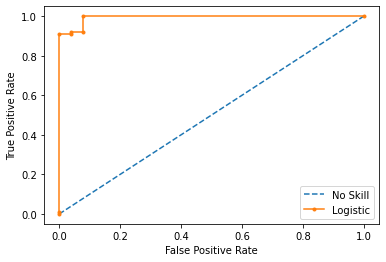

In [11]:
democratic_model.roc_curve(X_test,y_test)

Let's see how are doing the estimators of the pool individually :

In [12]:
best_model.get_scores(X_test,y_test)

[('random forest classifier', 1.0),
 ('Logistic Regression', 0.9473684210526315),
 ('Gaussian Naive Bayes', 0.956140350877193),
 ('LDA', 0.9473684210526315),
 ('xgb', 0.956140350877193)]

## What's next ? 

You can do the same steps with comprehensiveSearch set to True if you have the time and if you want to improve your results. You can also try new rulers and so ...

Maria, Thomas et Lucas.